In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import SR_IS_NHB, SR_NHB
from utils import policy_reval, woodbury, woodbury_SR, decision_policy_SR
from utils_render import plot_nhb_decisions, create_bar_plot, plot_decision_prob

In [2]:
# Set the random seed for NumPy
seed = 42
np.random.seed(42)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [4]:
## Hyperparameters for direct NHB comparison
lambd = 10
alpha = 0.15
alpha_SR = 0.15
beta = 0.6
num_steps = 200
num_iterations = 400

## Hyperparameters for "Normal" model
# lambd = 10
# alpha = 0.15
# alpha_SR = 0.15
# beta = 1.0
# num_steps = 250
# num_iterations = 400

In [5]:
def softmax(logits, temp=2.0):
    """softmax function for action selection"""
    exp_logits = np.exp(logits / temp - np.max(logits / temp))
    return exp_logits / np.sum(exp_logits)

# Policy Revaluation

## Run Simulations

### Complete Model

In [6]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="policy_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_complete["test"][dec_test] += 1

### TD Models

In [7]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_without_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Have the agents learn the environment
    # agent_with_imp.learn(seed=i)
    # agent_without_imp.learn(seed=i)
    # agent_SR.learn(seed=i)

    # Learn similarly to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_without_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)
    

    ##  SR  ##
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=4.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])  # Greedy action selection
    choices_sr["test"][dec_test] += 1


    ##  SR-IS  ##
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=5.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_with["test"][dec_test] += 1

    ##  SR-IS no Imp  ##
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=2.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_without["test"][dec_test] += 1


In [8]:
print(choices_with)
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}\n")
print(choices_sr)
print(f"selected state 1: {choices_sr['test'][0]/num_iterations}")

{'train': array([  0, 400]), 'test': array([216, 184])}
selected state 1: 0.54

{'train': array([  0, 400]), 'test': array([167, 233])}
selected state 1: 0.4175

{'train': array([  0, 400]), 'test': array([  7, 393])}
selected state 1: 0.0175


## Action Selection Probs

### Complete

In [9]:
prob_policy_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_policy_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [10]:
prob_policy_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_policy_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [11]:
# Train
prob_policy_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_policy_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_policy_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [12]:
# Train
prob_policy_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_policy_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_policy_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Reward Revaluation

## Run Simulations

### Complete Model

In [13]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="reward_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_complete["test"][dec_test] += 1

### TD Models

In [14]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_without_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Have the agents learn the environment
    # Learn normally
    # agent_with_imp.learn(seed=i)
    # agent_without_imp.learn(seed=i)
    # agent_SR.learn(seed=i)

    # Learn similar to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_without_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)


    ##  SR  ##
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=2.0) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])  # Greedy action selection
    choices_sr["test"][dec_test] += 1
    

    ##  SR-IS  ##
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.5)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])  # Greedy action selection
    choices_with["test"][dec_test] += 1


    ##  SR-IS no importance sampling  ##
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=2.0) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])  # Greedy action selection
    choices_without["test"][dec_test] += 1

In [15]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}\n")
print(choices_sr)
print(f"selected state 1: {choices_sr['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.7125

{'train': array([  0, 400]), 'test': array([244, 156])}
selected state 1: 0.61

{'train': array([  0, 400]), 'test': array([332,  68])}
selected state 1: 0.83


## Action Selection Probs

### Complete

In [16]:
prob_reward_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_reward_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [17]:
prob_reward_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_reward_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [18]:
# Train
prob_reward_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_reward_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_reward_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [19]:
# Train
prob_reward_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_reward_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_reward_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Transition Revaluation

## Run Simulations

### Complete Model

In [20]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, policy="softmax", imp_samp=True, exp_type="trans_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    T_new = agent_complete.construct_T_new()
    D_new = woodbury(agent=agent_complete, T=T_new, inv=False)
    agent_complete.DR = D_new
    agent_complete.update_Z()
    agent_complete.update_V()
    V_new = agent_complete.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0) 
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_complete["test"][dec_test] += 1

### TD Models

In [21]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_without_imp = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="trans_reval")
    agent_SR = SR_NHB(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Have the agents learn the environment
    # agent_with_imp.learn(seed=i)
    # agent_without_imp.learn(seed=i)
    # agent_SR.learn(seed=i)

    # Learn similar to NHB
    agent_with_imp.learn_with_start_locs(seed=i)
    agent_without_imp.learn_with_start_locs(seed=i)
    agent_SR.learn_with_start_locs(seed=i)


    ##  SR  ##
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1

    # Transition revaluation
    agent_SR.learn_trans_reval()

    # Softmax decision at test
    probs = softmax(logits=np.array([agent_SR.V[1], agent_SR.V[2]]), temp=2.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])  # Greedy action selection
    choices_sr["test"][dec_test] += 1


    ##  SR-IS  ##
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_with_imp.construct_T_new()
    D_new = woodbury(agent=agent_with_imp, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent_with_imp.DR = D_new
    agent_with_imp.update_Z()
    agent_with_imp.update_V()
    V_new = agent_with_imp.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=5.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_with["test"][dec_test] += 1


    ##  SR-IS no importance sampling  ##
    # Original training task
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_without_imp.construct_T_new()
    D_new = woodbury(agent=agent_without_imp, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent_without_imp.DR = D_new
    agent_without_imp.update_Z()
    # agent_without_imp.Z += np.abs(np.min(agent_without_imp.Z)) + 0.5
    agent_without_imp.update_V()
    V_new = agent_without_imp.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=5.0)
    dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    # dec_test = np.argmax([V_new[1], V_new[2]])   # Greedy action selection
    choices_without["test"][dec_test] += 1

In [22]:
print(choices_with)
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")
print(choices_sr)
print(f"selected state 1: {choices_sr['test'][0]/num_iterations}")

{'train': array([  0, 400]), 'test': array([219, 181])}
selected state 1: 0.5475

{'train': array([  0, 400]), 'test': array([189, 211])}
selected state 1: 0.4725
{'train': array([  0, 400]), 'test': array([  5, 395])}
selected state 1: 0.0125


## Action Selection Probs

### Complete

In [23]:
prob_transition_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_transition_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [24]:
prob_transition_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_transition_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [25]:
# Train
prob_transition_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_transition_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_transition_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [26]:
# Train
prob_transition_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_transition_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_transition_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Plot Simulation Results

## With Importance Sampling

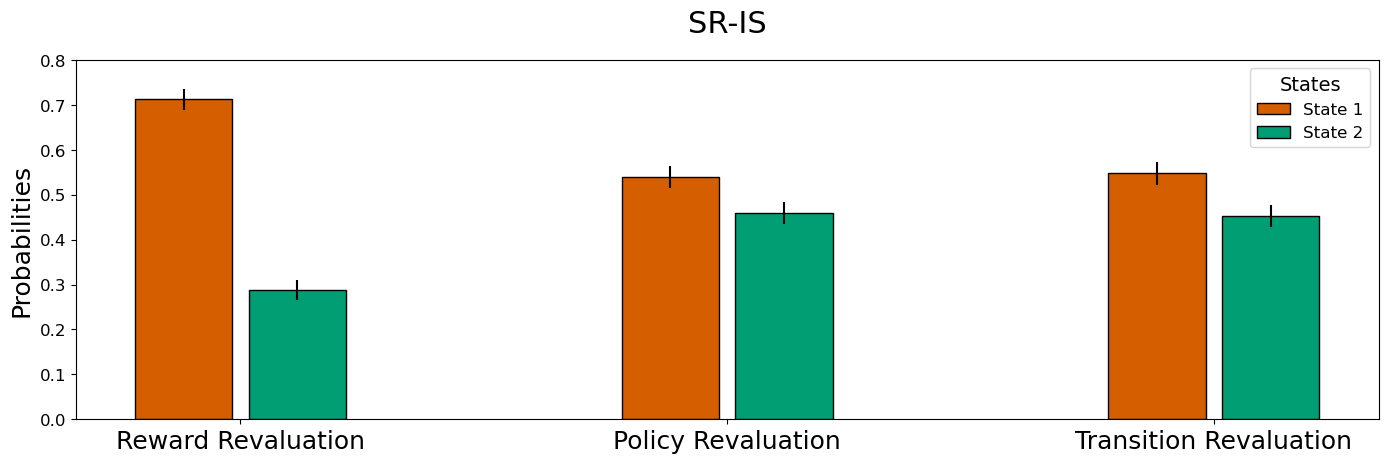

In [27]:
# save_path = save_dir + "nhb_simulations_with.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_with,
    probs_policy=prob_policy_with,
    probs_transition=prob_transition_with,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='SR-IS',
    std=[std_reward_with, std_policy_with, std_transition_with]
)

## Without Importance Sampling

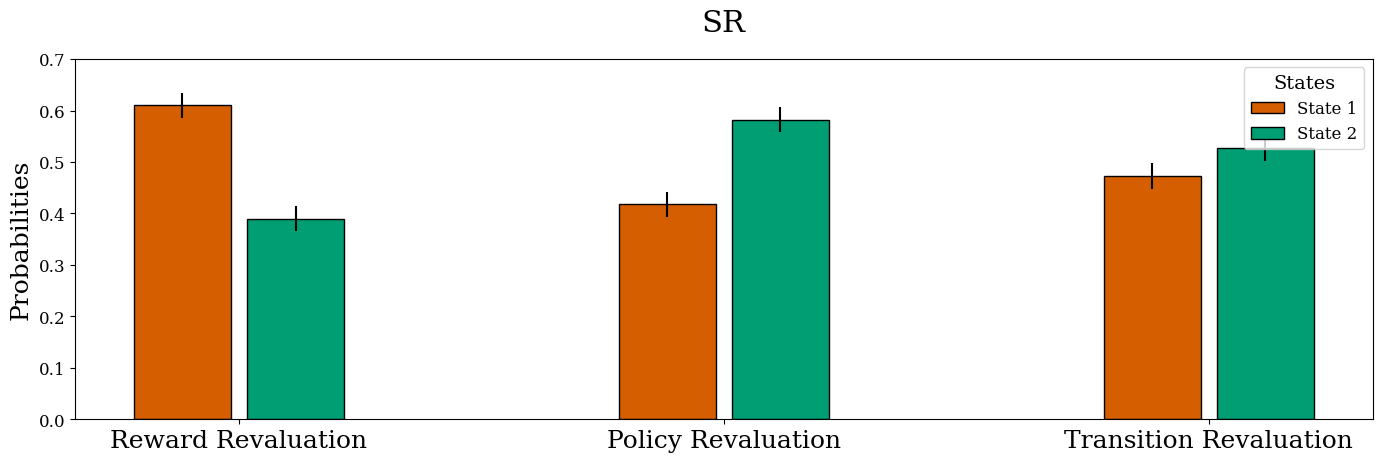

In [28]:
# save_path = save_dir + "nhb_simulations_without.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_without,
    probs_policy=prob_policy_without,
    probs_transition=prob_transition_without,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='SR',
    std=[std_reward_without, std_policy_without, std_transition_without]
)

# Plot NHB values against ours

In [46]:
def create_bar_plot(means, colors, ylabel, xlabels, std=None, title=None, save_path=None):
    """
    Another bar plot for decision probabilities, this one is exclusive to the NHB Decision probs

    Args:
        means (array) : mean of each bar to plot
        colors (list) : idx of color palette color to use
        ylabel (string) : label for the y-axis
        xlabels (list of strings) : labels for the x-axis
        std (array, optional) : std error of each bar
        title (string, optional) : title of the plot
        save_path (string, optional) : where to save the figure
    """
    color_palette = sns.color_palette("colorblind")
    color_list = []
    for color in colors:
        color_list.append(color_palette[color])

    # Set the style and font
    plt.rcParams['font.family'] = 'serif'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 5))
    x = np.arange(len(means)) * 0.25
    
    # Plot the bars with black edge color
    bars = ax.bar(x, means, color=color_list, edgecolor='black', linewidth=1, width=0.15)
    
    # Add error bars if std is provided
    if std is not None:
        ax.errorbar(x, means, yerr=std, fmt='none', color='black', capsize=0)
    
    # Customize the plot
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=18) if title else None
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=0, ha='center', fontsize=14)
    
    # Set y-axis limits and ticks
    ax.set_ylim(0.2, 1.1)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Add black border to all spines
    for spine in ['left', 'right', 'bottom', 'top']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1)
    
    # Remove grid
    ax.grid(False)
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

## NHB reconstruction

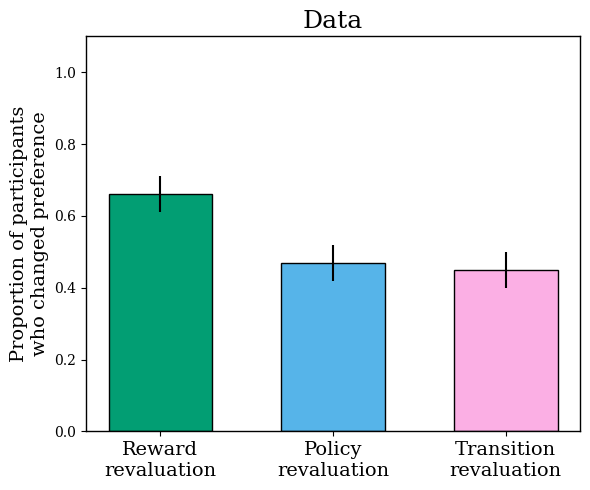

In [53]:
save_path = save_dir + "NHB_data.png"
# save_path = None
nhb_means = [0.66, 0.47, 0.45]
nhb_stds = [0.05, 0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Proportion of participants\nwho changed preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data")

## With Importance Sampling

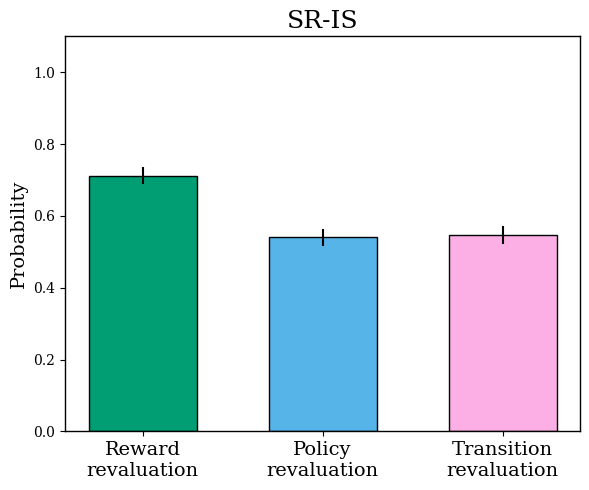

In [48]:
save_path = save_dir + "NHB_with_imp.png"
# save_path = None
means = [prob_reward_with[0], prob_policy_with[0], prob_transition_with[0]]
stds = [std_reward_with, std_policy_with, std_transition_with]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR-IS")

## SR

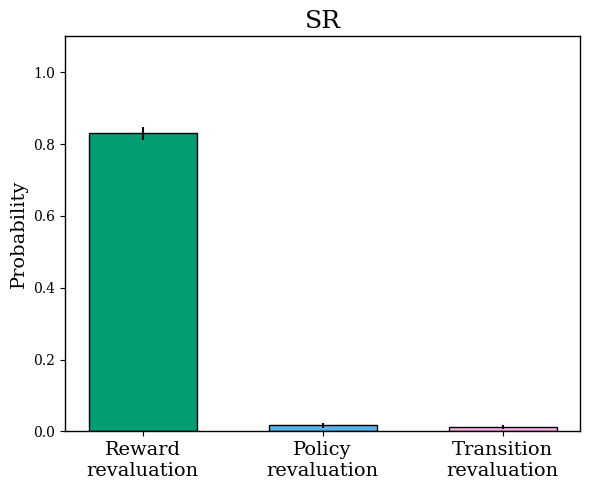

In [52]:
save_path = save_dir + "NHB_SR.png"
# save_path = None
means = [prob_reward_sr[0], prob_policy_sr[0], prob_transition_sr[0]]
stds = [std_reward_sr, std_policy_sr, std_transition_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR")

## Complete Model

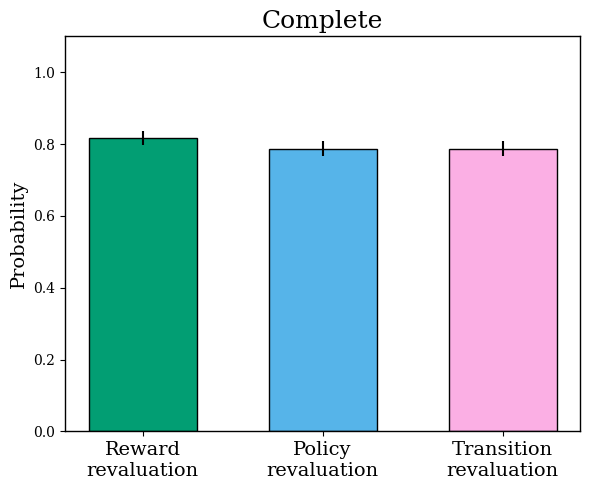

In [51]:
save_path = save_dir + "NHB_Complete.png"
# save_path = None
means = [prob_reward_complete[0], prob_policy_complete[0], prob_transition_complete[0]]
stds = [std_reward_complete, std_policy_complete, std_transition_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation', 'Transition\nrevaluation']
colors = [2, 9, 6]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Complete")

<br> <br> <br>

# Supp. Figures contain both with and without importance sampling

## Reward Revaluation

### With importance sampling

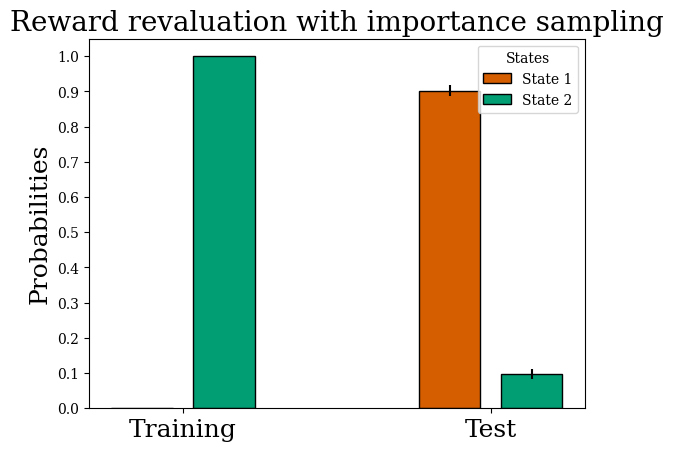

In [30]:
plot_decision_prob(probs_train=prob_reward_with_train, probs_test=prob_reward_with, title="Reward revaluation with importance sampling", 
                   std=[std_reward_with_train, std_reward_with], colors=colors, save_path=None)

### Without importance sampling

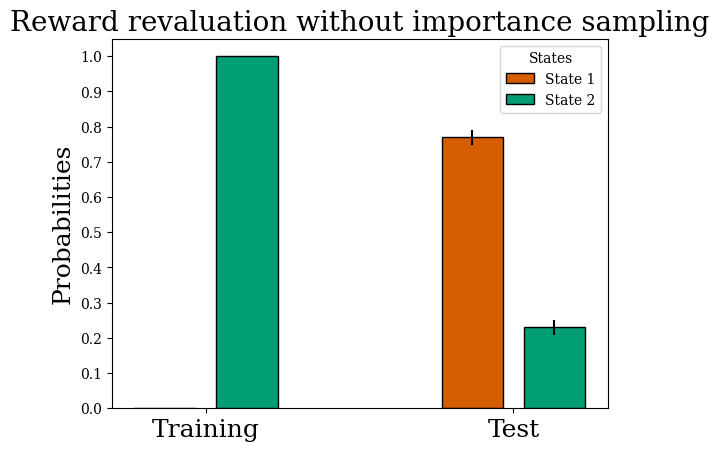

In [31]:
plot_decision_prob(probs_train=prob_reward_without_train, probs_test=prob_reward_without, title="Reward revaluation without importance sampling", 
                   std=[std_reward_without_train, std_reward_without], colors=colors, save_path=None)

## Policy Revaluation

### With importance sampling

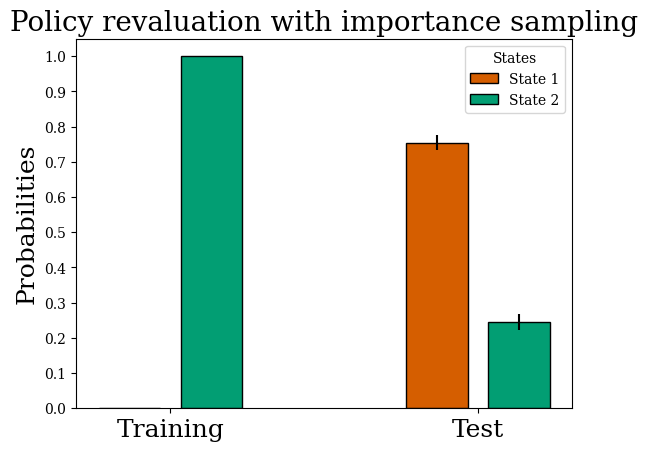

In [32]:
plot_decision_prob(probs_train=prob_policy_with_train, probs_test=prob_policy_with, title="Policy revaluation with importance sampling", 
                   std=[std_policy_with_train, std_policy_with], colors=colors, save_path=None)

### Without importance sampling

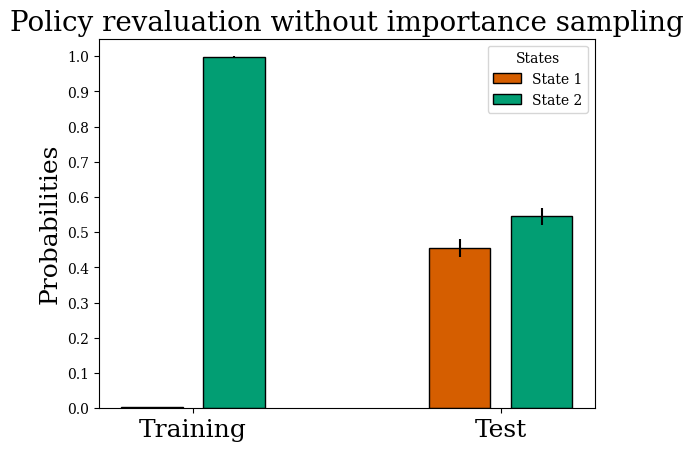

In [33]:
plot_decision_prob(probs_train=prob_policy_without_train, probs_test=prob_policy_without, title="Policy revaluation without importance sampling", 
                   std=[std_policy_without_train, std_policy_without], colors=colors, save_path=None)

## Transition Revaluation

### With importance sampling

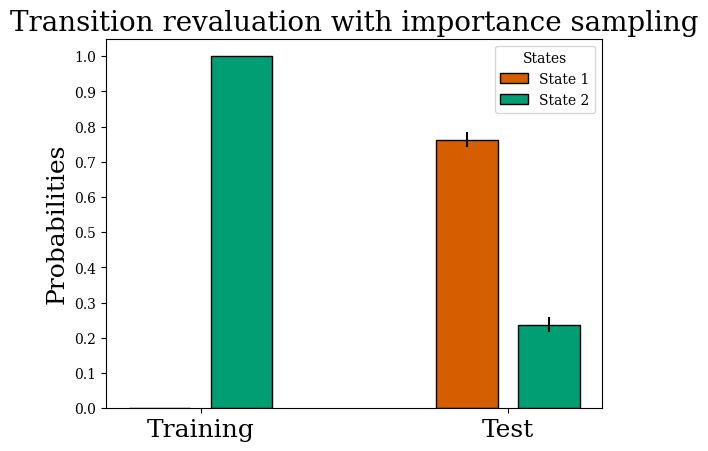

In [34]:
plot_decision_prob(probs_train=prob_transition_with_train, probs_test=prob_transition_with, title="Transition revaluation with importance sampling", 
                   std=[std_transition_with_train, std_transition_with], colors=colors, save_path=None)

### Without importance sampling

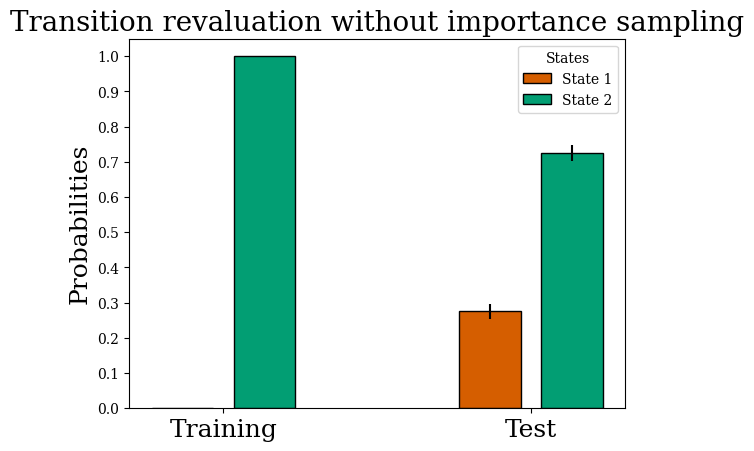

In [35]:
plot_decision_prob(probs_train=prob_transition_without_train, probs_test=prob_transition_without, title="Transition revaluation without importance sampling", 
                   std=[std_transition_without_train, std_transition_without], colors=colors, save_path=None)